# 0.0 Import Libraries

In [272]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

import math 
import inflection
import datetime

from IPython.display import Image
from tabulate        import tabulate
from scipy           import stats as ss

# 0.1 Load Data

In [2]:
# reading data
df_sales_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )

# merging datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 0.2 Functions

In [300]:
# rename columns to snakecase style
def rename_columns(dataframe):
    df = dataframe.copy()

    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new
    
    return df

# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    


# 1.0 Descriptive Data Analysis

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
df1 = rename_columns( df1 )
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [6]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [7]:
# list data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
# number of rows with NA values by column
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance 
# competition_distance with NA values means "no competitor around". 
# Set max value mutiplied by 3 in the null rows

max_value = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: max_value*3 if math.isnan( x ) else x )

print(f'Old Max Value of competition distance: { max_value } ' )
print(f'New Max Value of competition distance: { df1["competition_distance"].max() } ' )


Old Max Value of competition distance: 75860.0 
New Max Value of competition distance: 227580.0 


In [11]:
# competition_open_since_month and competition_open_since_year 
# Set month and year of sale as default value

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year']  = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )   else x['competition_open_since_year'], axis=1 )

In [12]:
# promo2_since_week  and promo2_since_year
# Set month and year of sale as default value

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [13]:
# promo_interval  

# first, create a new column(month_map) with the month of sale  
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['promo_interval'].fillna( 0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )

# second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 


df1.sample(5).T

,448471,972764,10281,930385,854717
store,1027,155,247,146,298
day_of_week,1,6,3,2,7
date,2014-05-26 00:00:00,2013-02-09 00:00:00,2015-07-22 00:00:00,2013-03-19 00:00:00,2013-05-26 00:00:00
sales,9232,6903,5450,8756,0
customers,1236,707,472,731,0
open,1,1,1,1,0
promo,0,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,d,d,d


## 1.6 Change Types

In [14]:
# change data types from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [15]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
414396,0,c,c,"Jan,Apr,Jul,Oct",Jun
65174,0,a,a,"Feb,May,Aug,Nov",Jun


### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [17]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

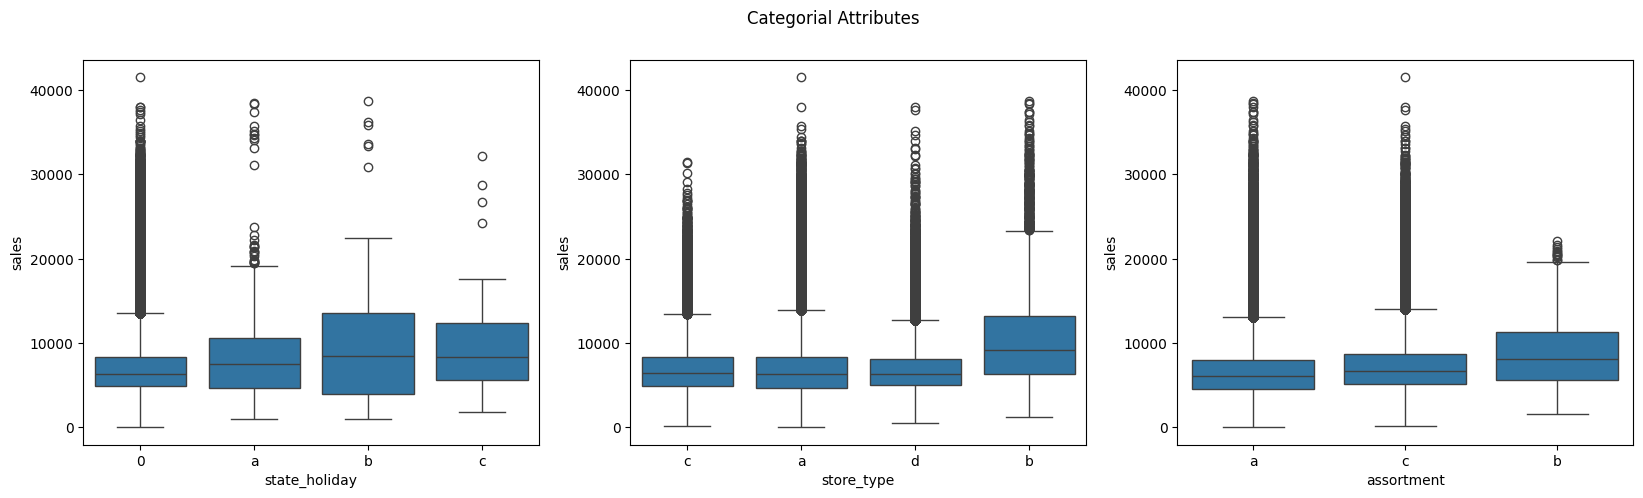

In [119]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

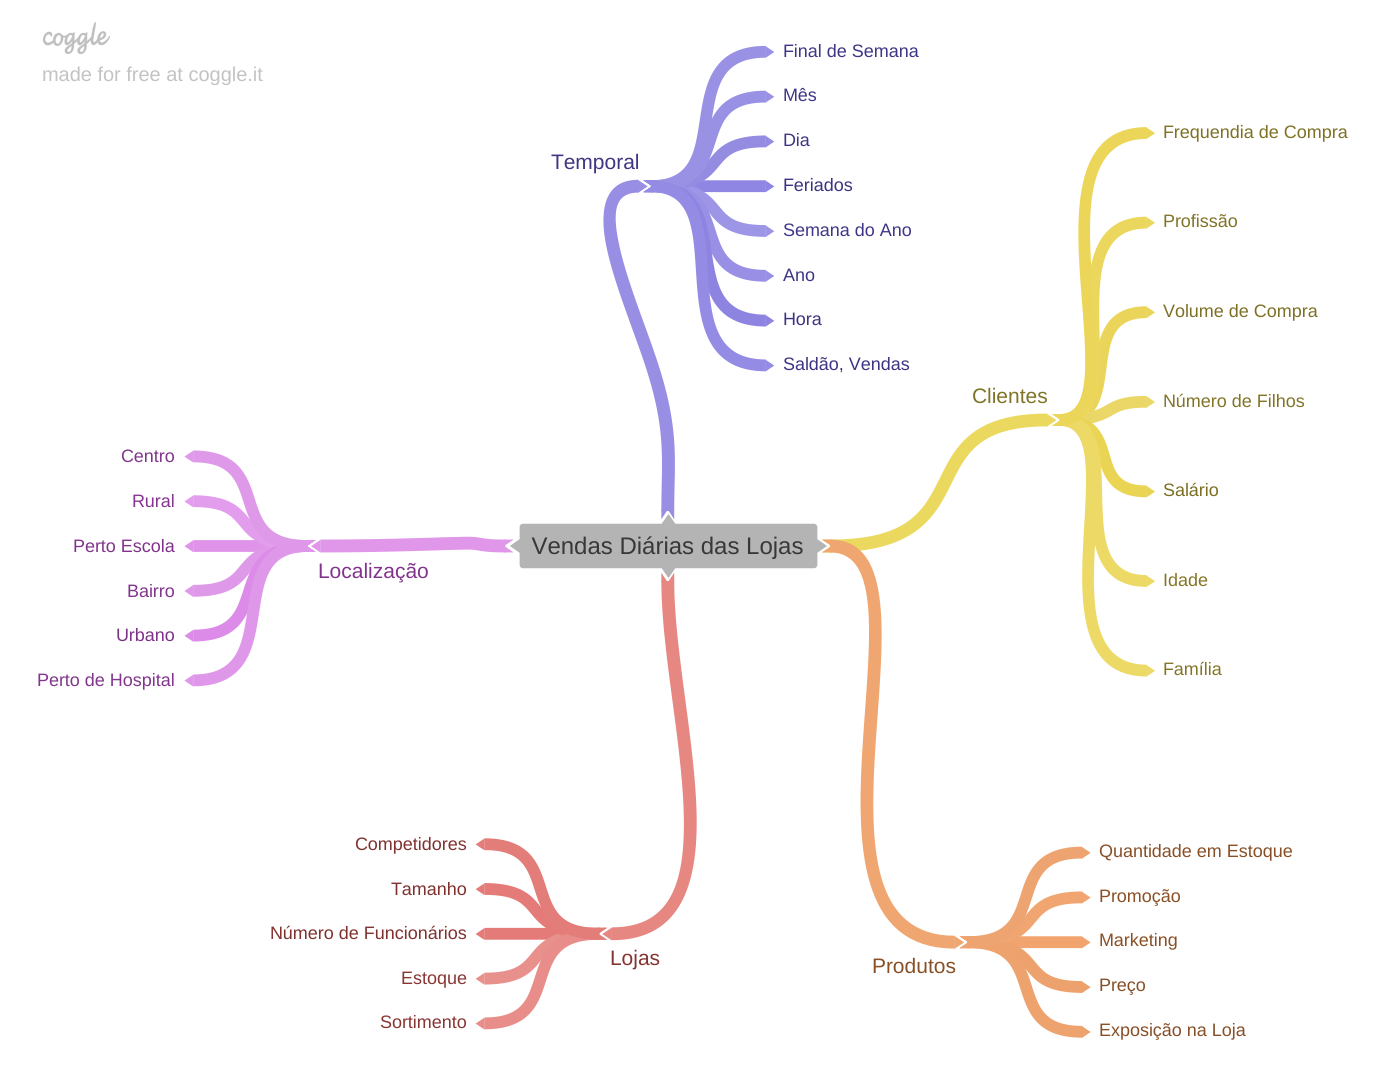

In [20]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

### 2.4.1 From date column

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

# year week
df2['year_week'] = df2.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
797401,2013-07-17,2013,7,17,29,2013-29
689853,2013-10-21,2013,10,21,43,2013-43
838897,2013-06-09,2013,6,9,23,2013-23
399942,2014-07-10,2014,7,10,28,2014-28
316517,2014-10-07,2014,10,7,41,2014-41


### 2.4.2 From competition_open_since columns

In [22]:
df2['competition_since']      = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = df2.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
213190,2015-01-21,2015,1,2015-01-01,0
23001,2015-07-11,2001,9,2001-09-01,168
342313,2014-09-09,2014,7,2014-07-01,2
141545,2015-03-27,2015,3,2015-03-01,0
82997,2015-05-18,2014,4,2014-04-01,13


### 2.4.3 From promo2_since columns

In [23]:
df2['promo2_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since']     = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo2_time_week'] = df2.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
836742,2013,24,2013-06-10,2013-06-11,0
66247,2015,23,2015-06-01,2015-06-02,0
569340,2013,5,2013-01-28,2014-02-06,53
638195,2013,31,2013-07-29,2013-12-06,18
589029,2011,14,2011-03-28,2014-01-20,147


### 2.4.4 From assorment column

In [24]:
#  describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )
df2['assortment'].value_counts()

assortment
basic       537445
extended    471470
extra         8294
Name: count, dtype: int64

### 2.4.5 From state_holiday column

In [25]:
#StateHoliday - indicates a state holiday. 
#Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
#a = public holiday, b = Easter holiday, c = Christmas, 0 = regular day

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day' )
df2['state_holiday'].value_counts()


state_holiday
regular day       986159
public holiday     20260
Easter holiday      6690
Christmas           4100
Name: count, dtype: int64

## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [26]:
# remove lines where there are no sales 
df2 = df2[ ( df2['open'] != 0 ) & ( df2['sales'] > 0 ) ]
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
306587,97,5,2014-10-17,5596,683,1,0,regular day,0,d,...,0,2014,10,17,42,2014-42,2014-10-01,0,2014-10-13,0
164581,677,5,2015-03-06,7528,596,1,1,regular day,0,d,...,0,2015,3,6,10,2015-10,2014-06-01,9,2009-11-02,278
103316,737,4,2015-04-30,10837,1304,1,1,regular day,0,a,...,1,2015,4,30,18,2015-18,2007-05-01,97,2013-07-29,91
869090,176,1,2013-05-13,7572,819,1,1,regular day,0,a,...,0,2013,5,13,20,2013-20,2013-05-01,0,2013-05-13,0
553930,561,4,2014-02-20,7565,744,1,1,regular day,0,d,...,0,2014,2,20,8,2014-8,2014-02-01,0,2014-02-17,0


### 2.5.2 Filtering Columns

In [27]:
# customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
# open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
# sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
# colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df2 = df2.drop( cols_drop, axis=1 )
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

# 3.0 Exploratory Data Analysis

In [28]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

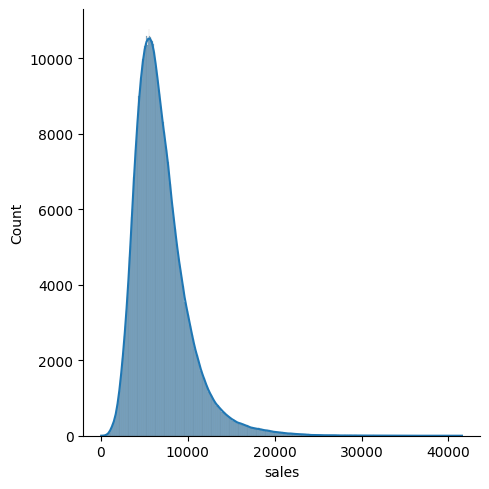

In [29]:
# checking distribuition 
sns.displot( df3['sales'], kde='hist');

### 3.1.2 Numerical Variables

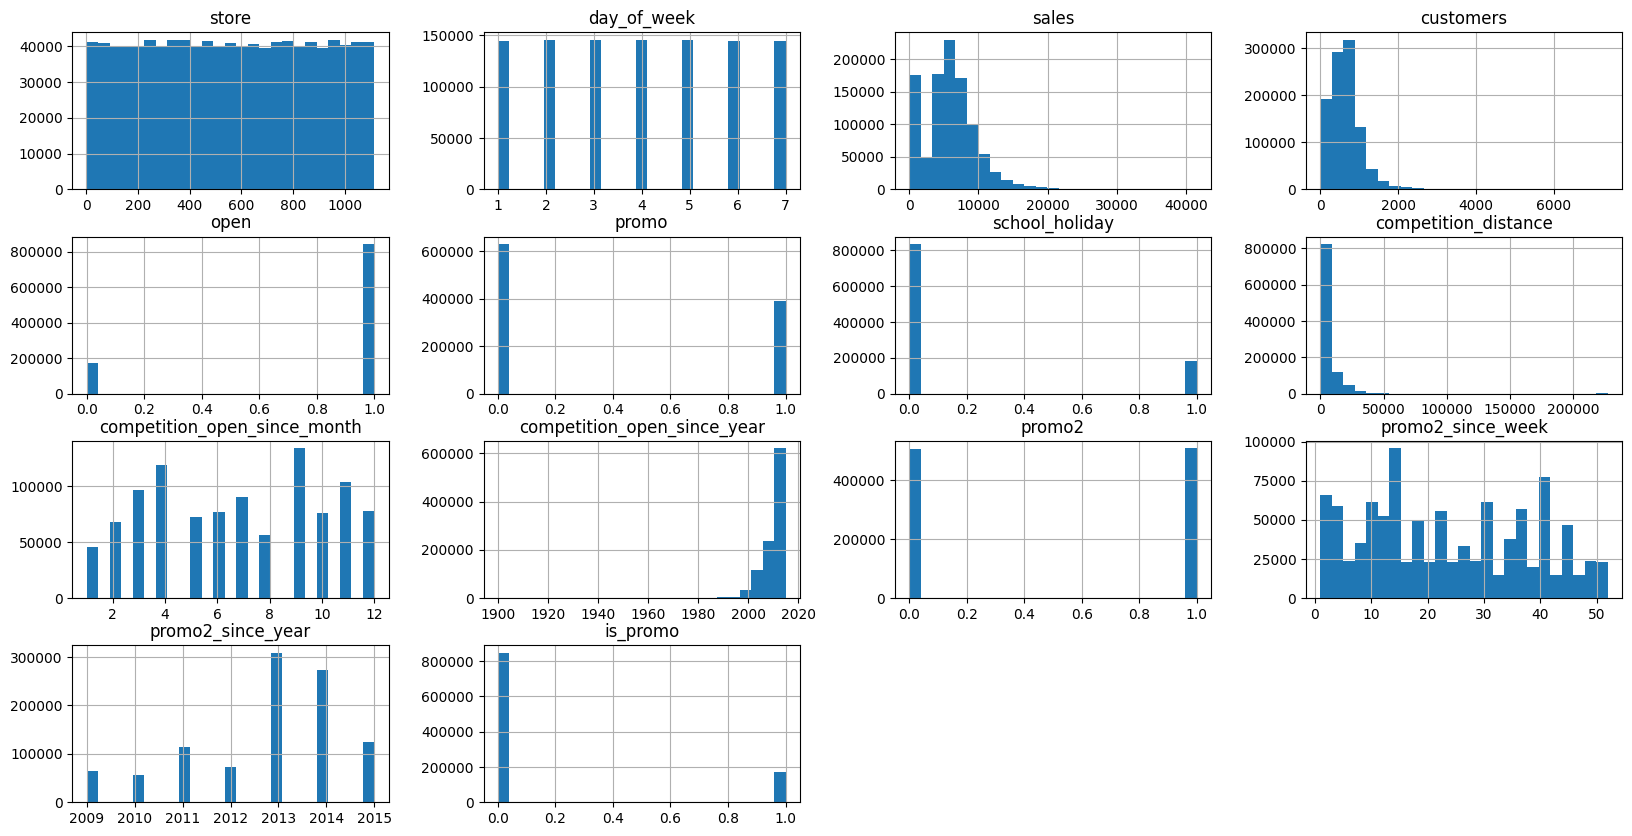

In [30]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

##### Notas do gráfico: 

**1.** A variável "competition_open_since_month" apresenta vários comportamentos, e quantos mais comportamentos uma variável possui melhor para o aprendizado do modelo.

**2.** Já a variável "day_of_week" apresenta um comportamente constante, não há variação, esse tipo de variável sozinha não serve para o aprendizado modelo

### 3.1.3 Categorical Variables

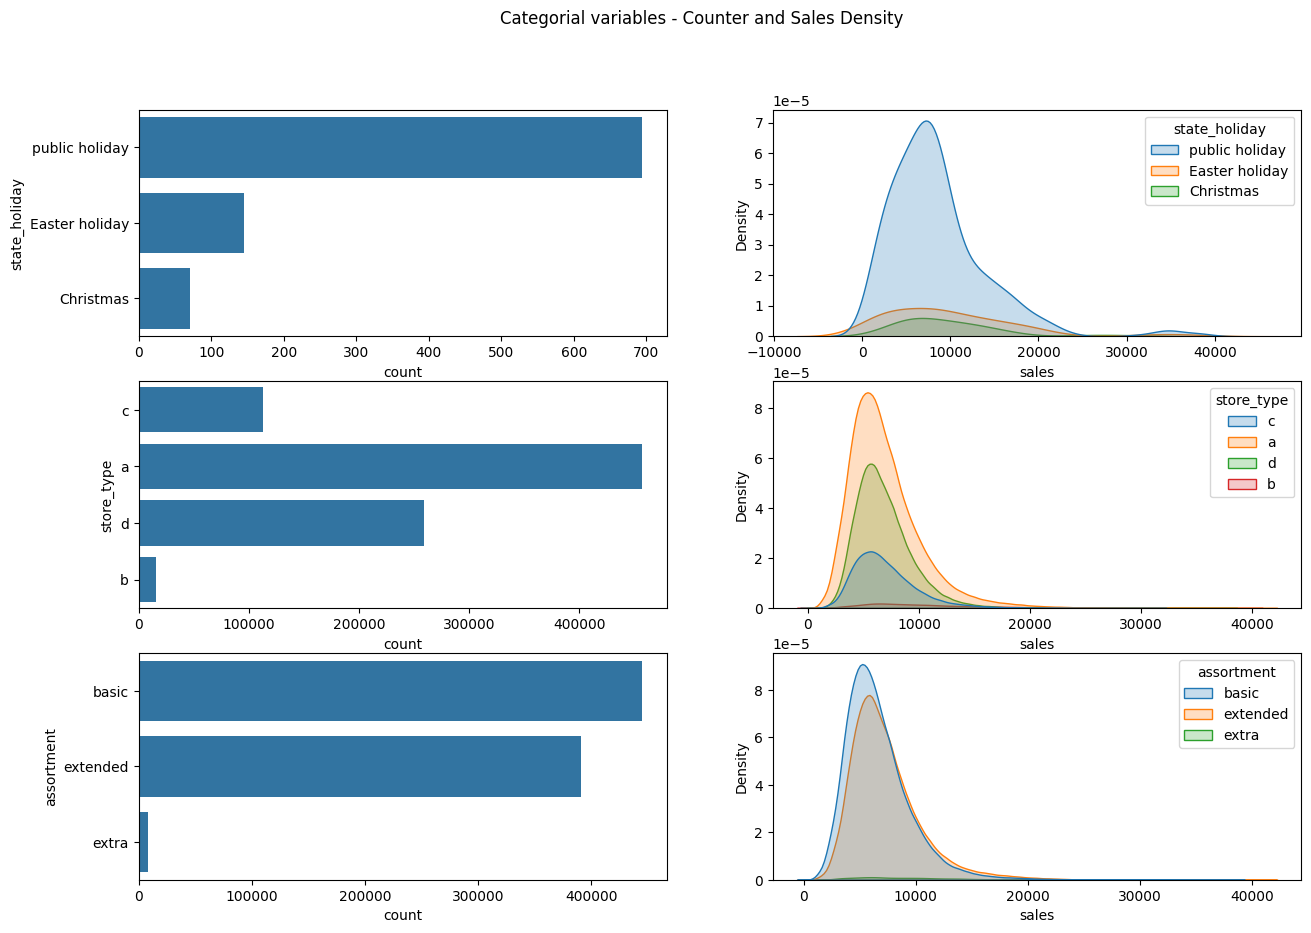

In [114]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.countplot( ax=axes[0,0], data=df3[ df3['state_holiday'] !=  'regular day' ]['state_holiday'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[ df3['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True );

# store_type
sns.countplot( ax=axes[1,0], data=df3['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.countplot( ax=axes[2,0], data=df3['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

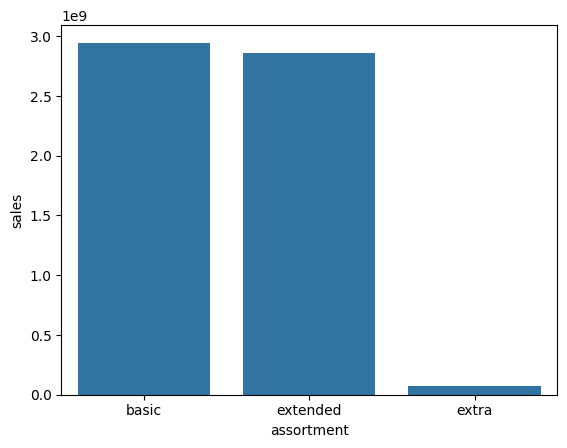

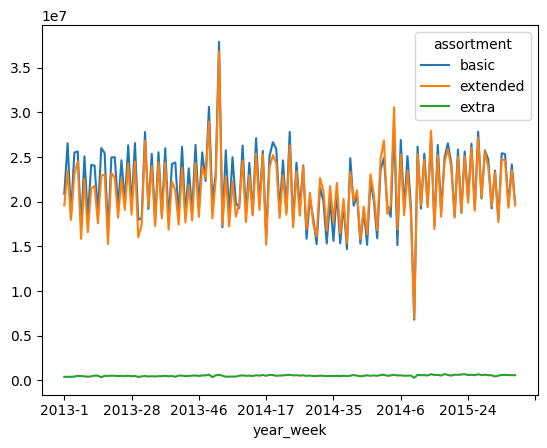

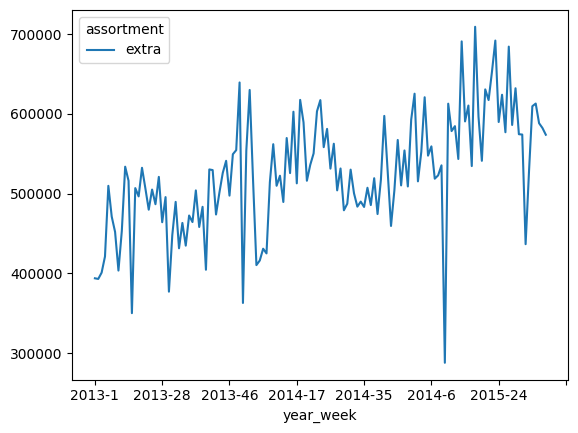

In [132]:
# sales x assortments - total
aux = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

/tmp/ipykernel_11607/3322249751.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()


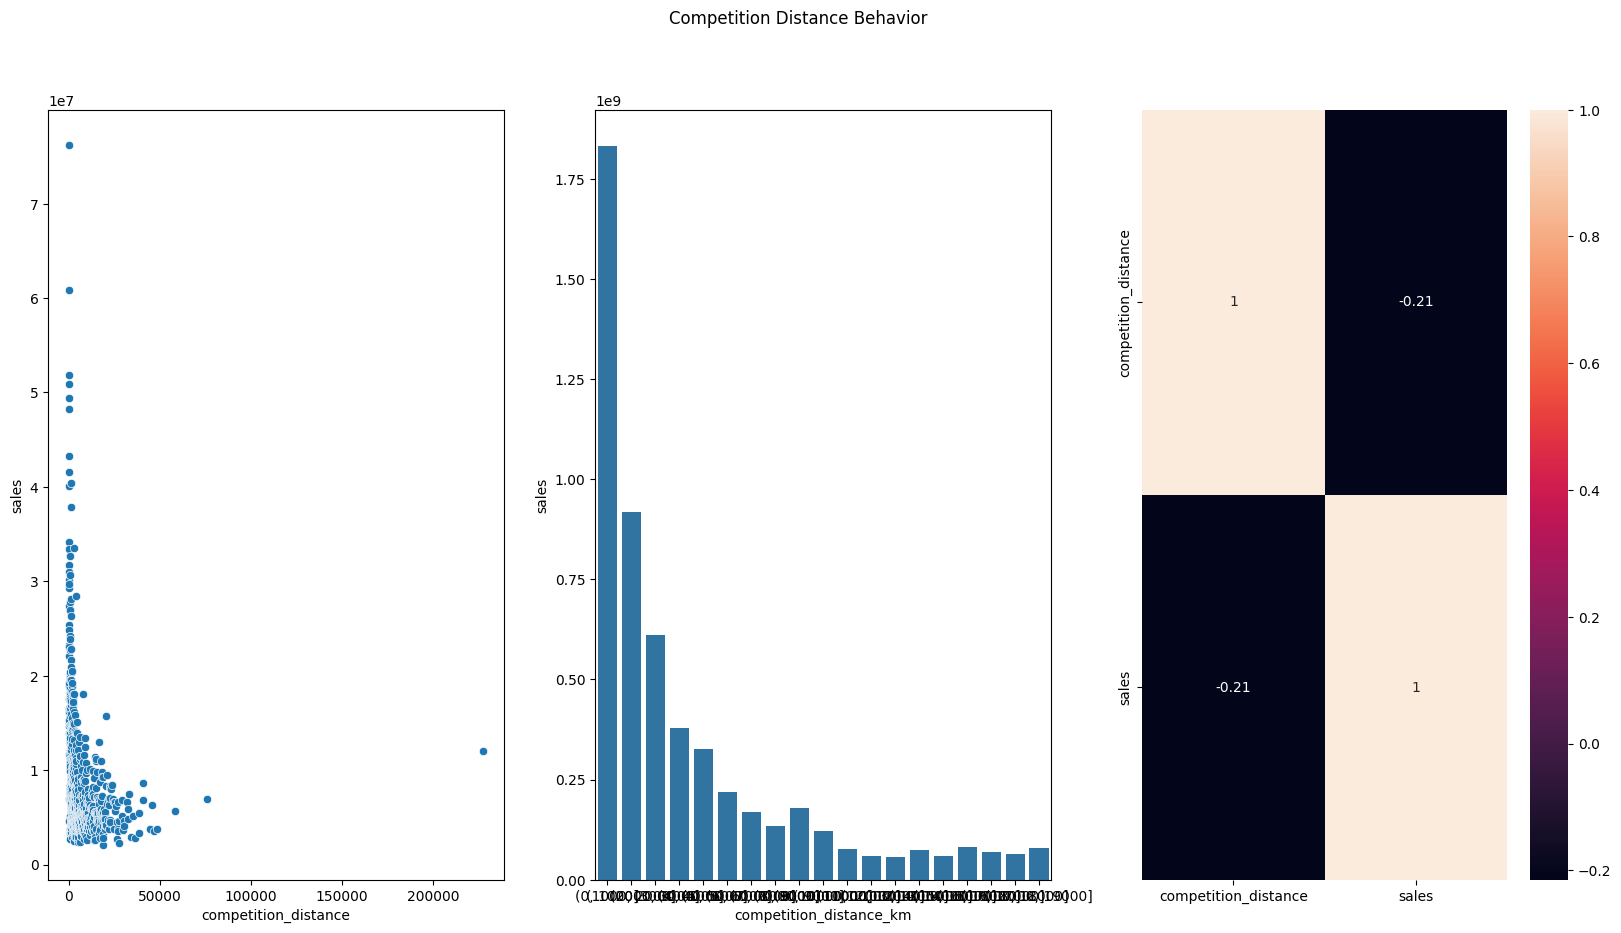

In [175]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

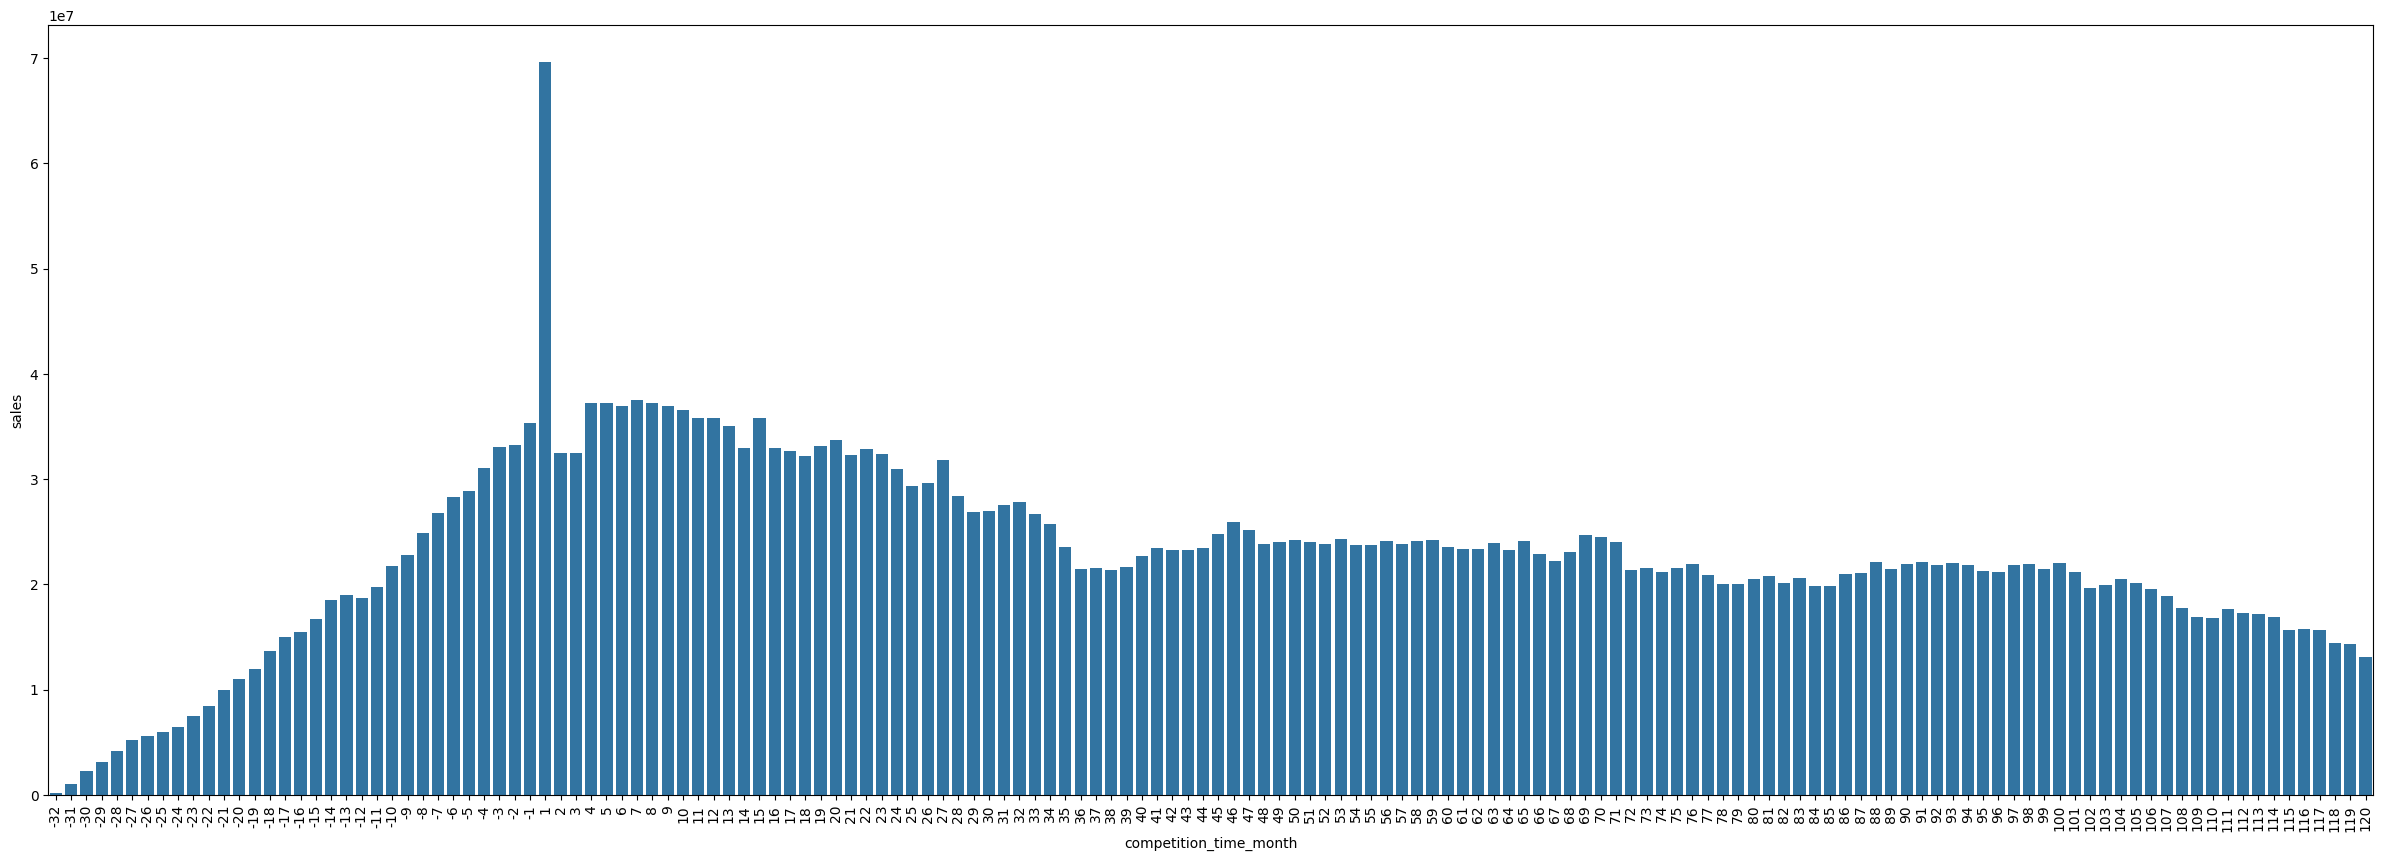

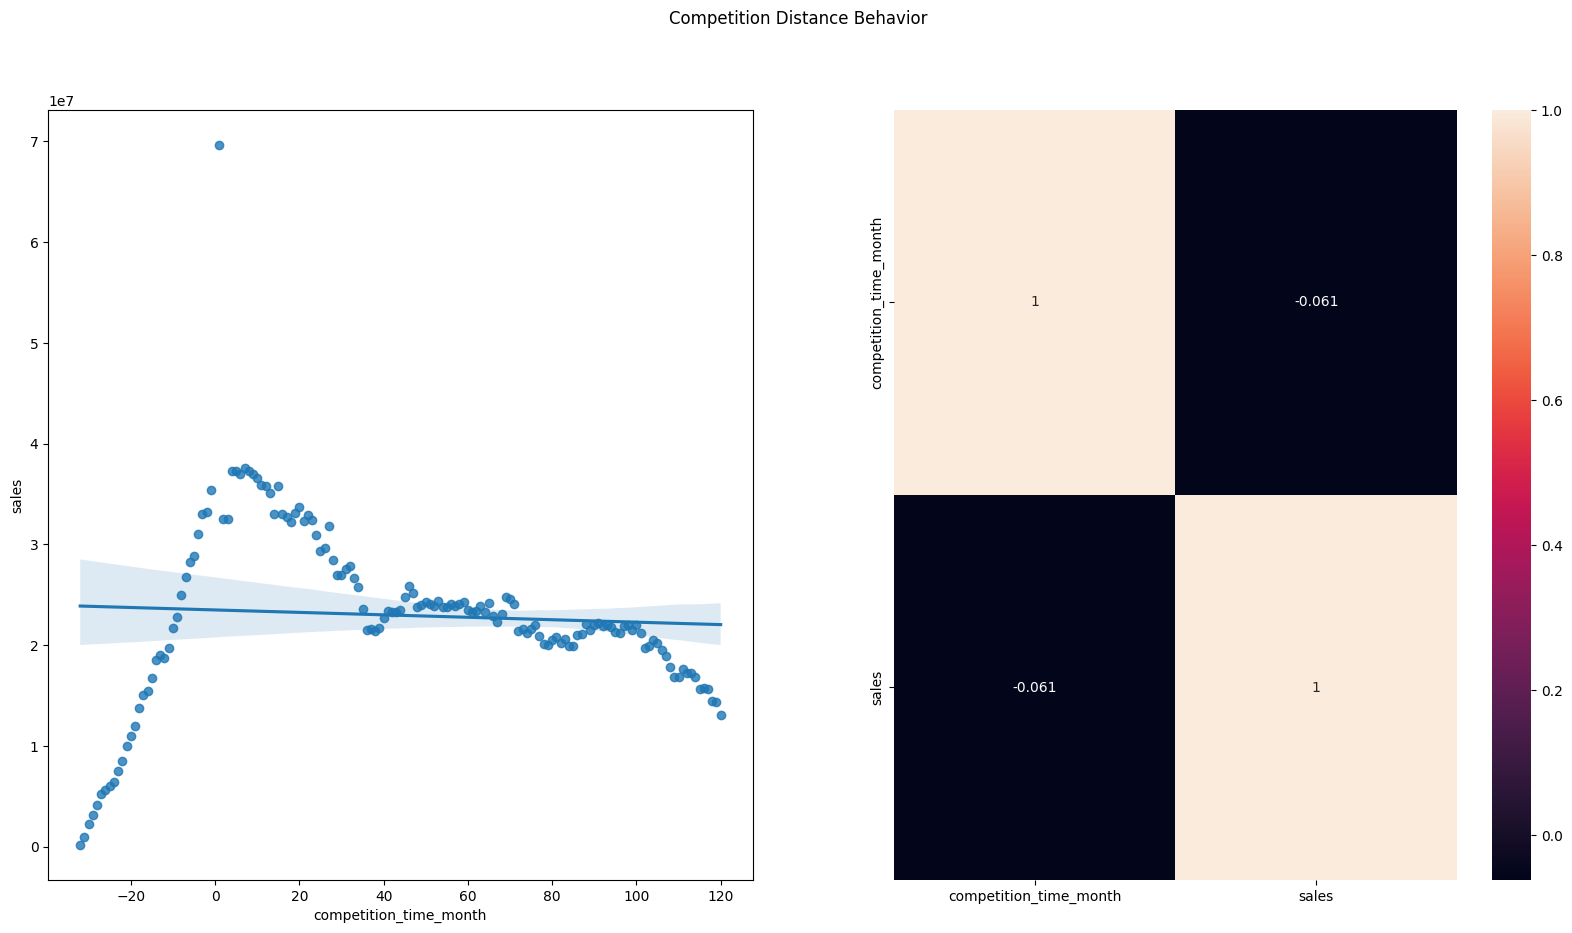

In [187]:
aux1 = df3[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

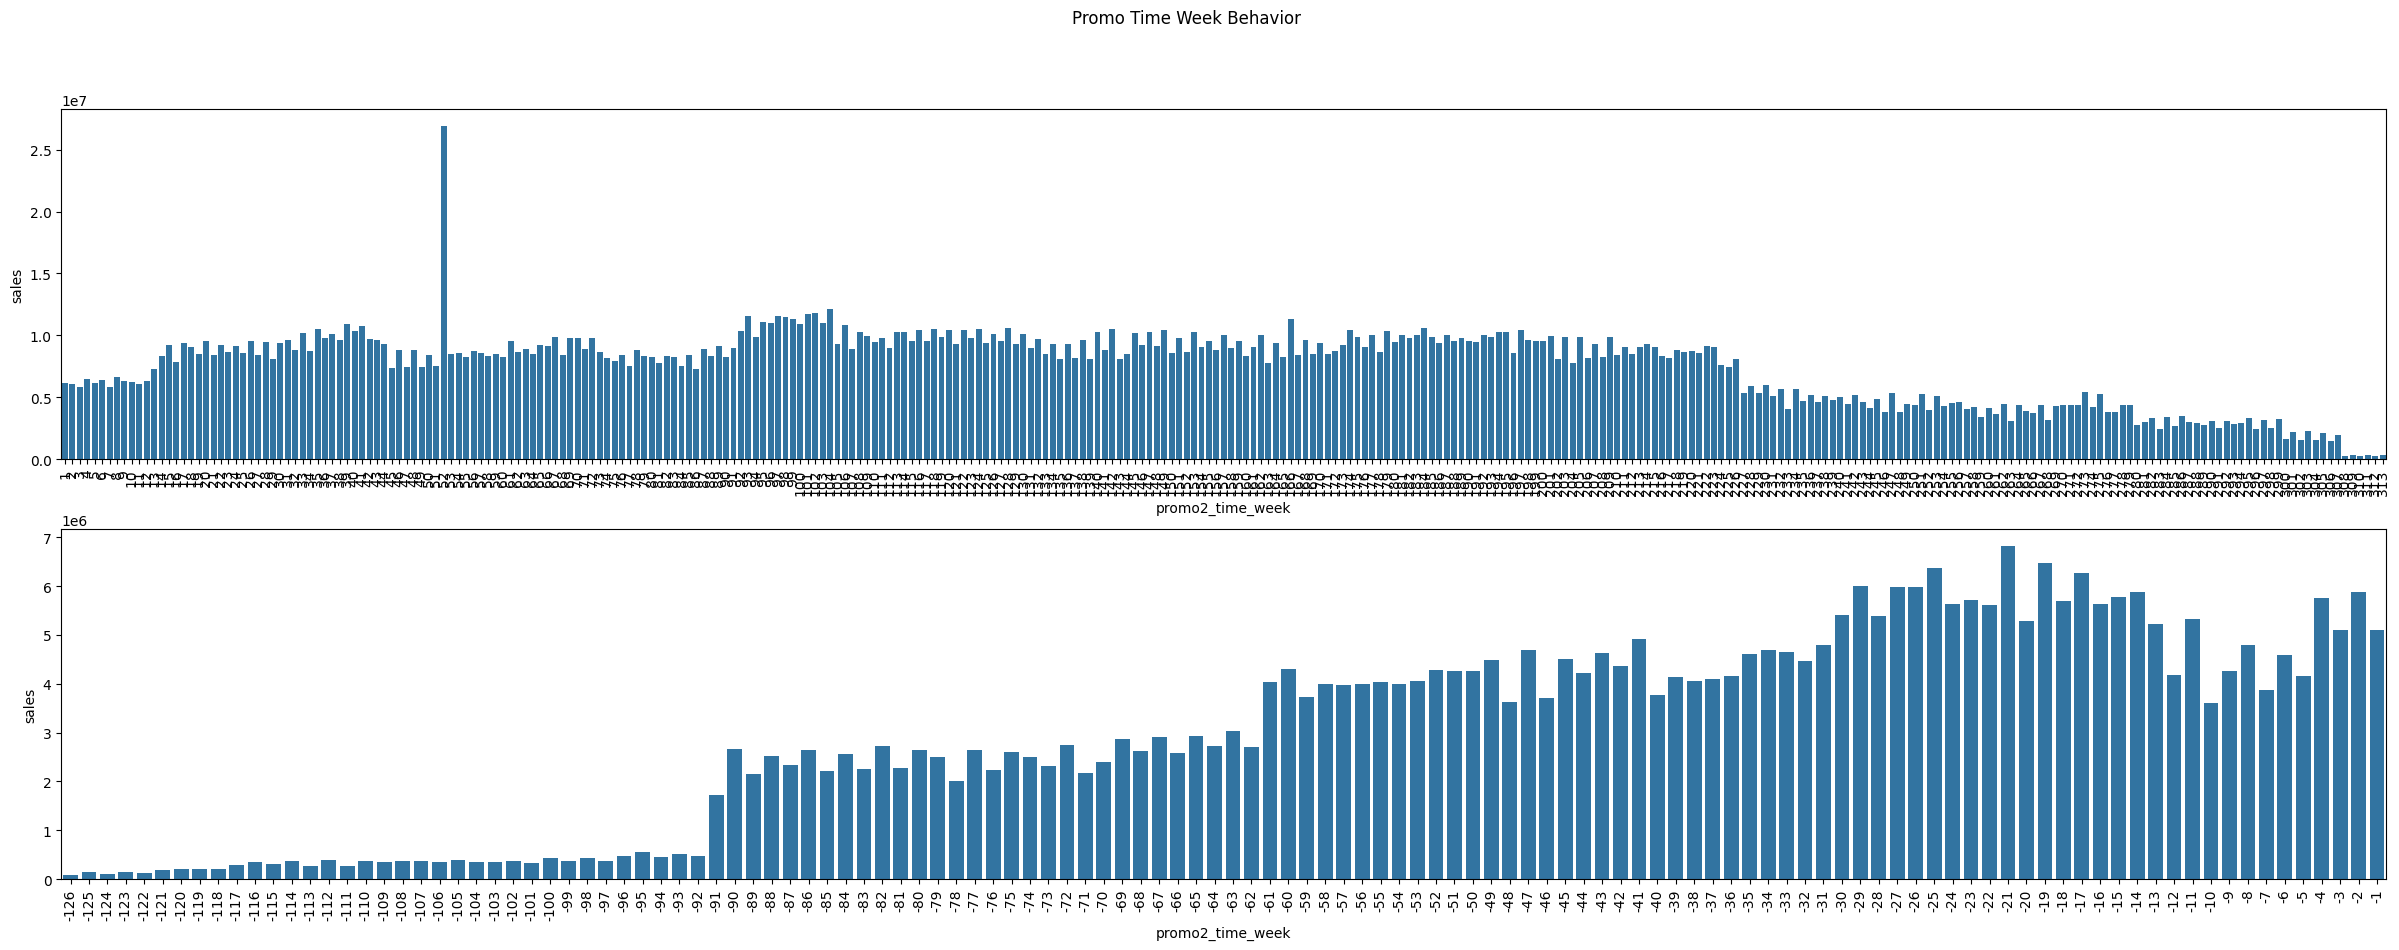

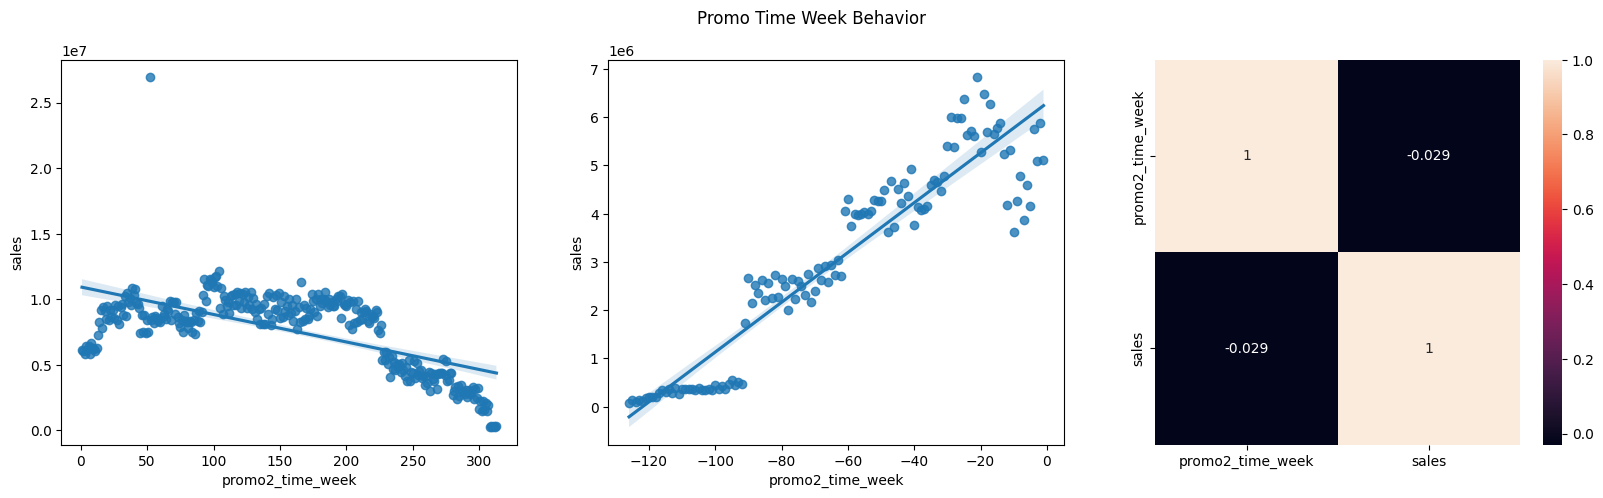

In [235]:
aux1 = df3[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

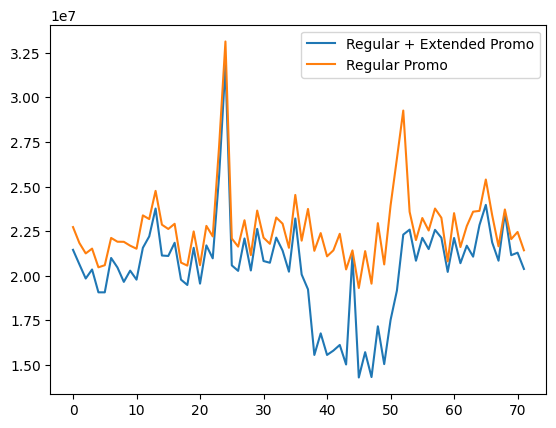

In [226]:
# regular and extended promo
aux1 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

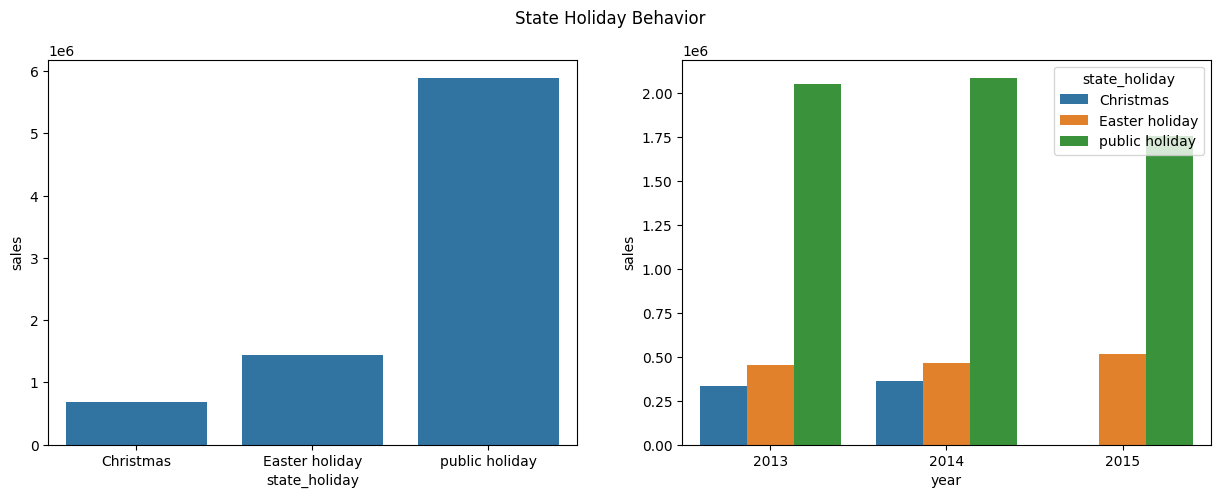

In [246]:
aux1 = df3[ df3['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df3[ df3['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

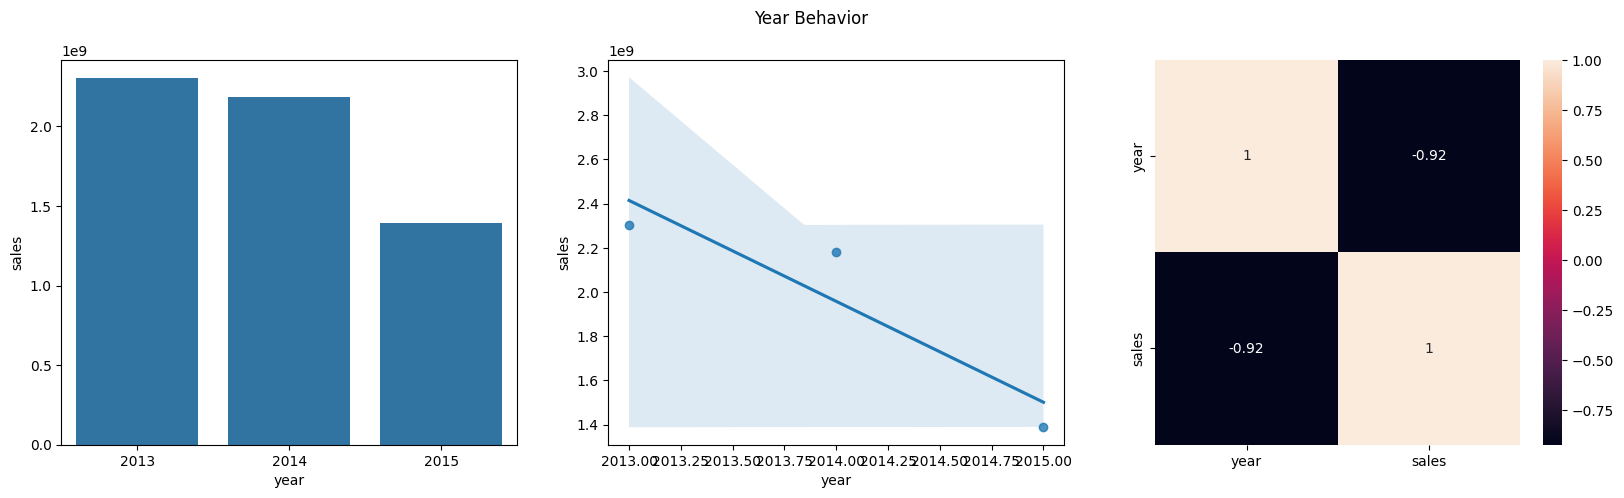

In [250]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

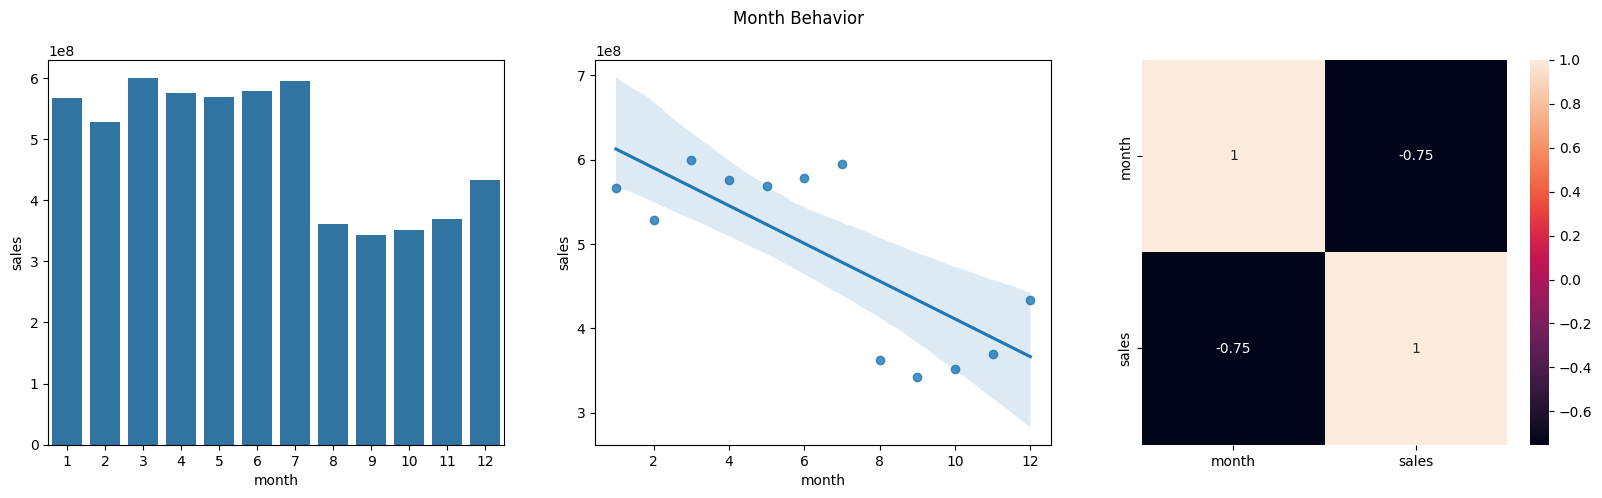

In [251]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

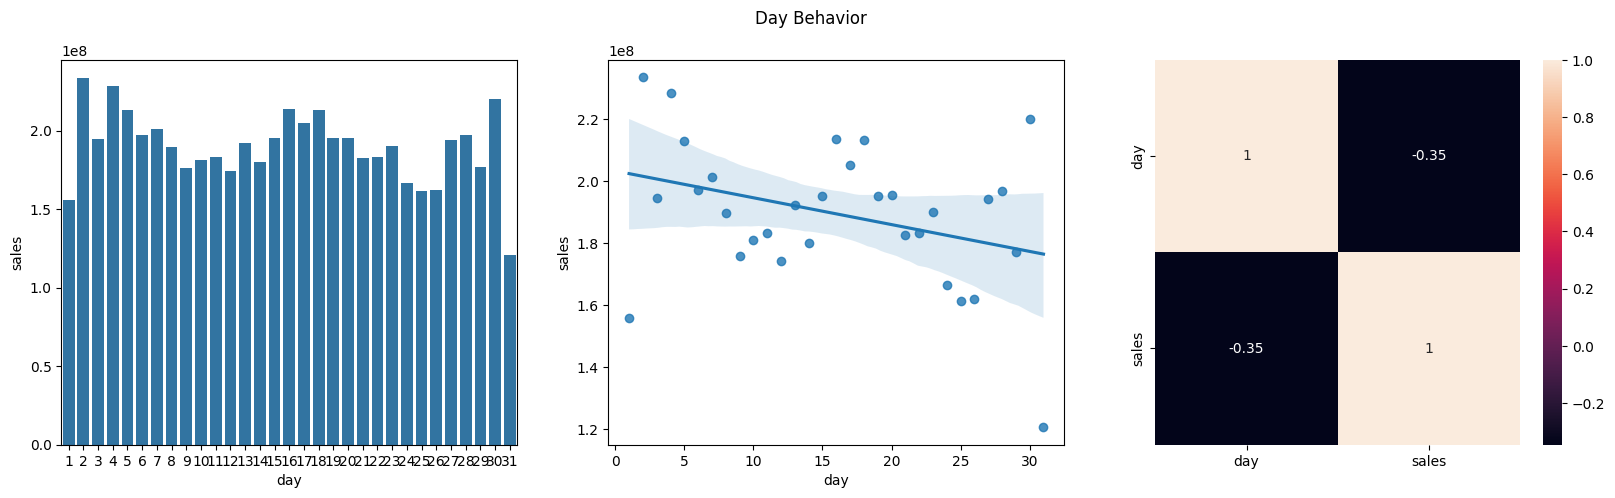

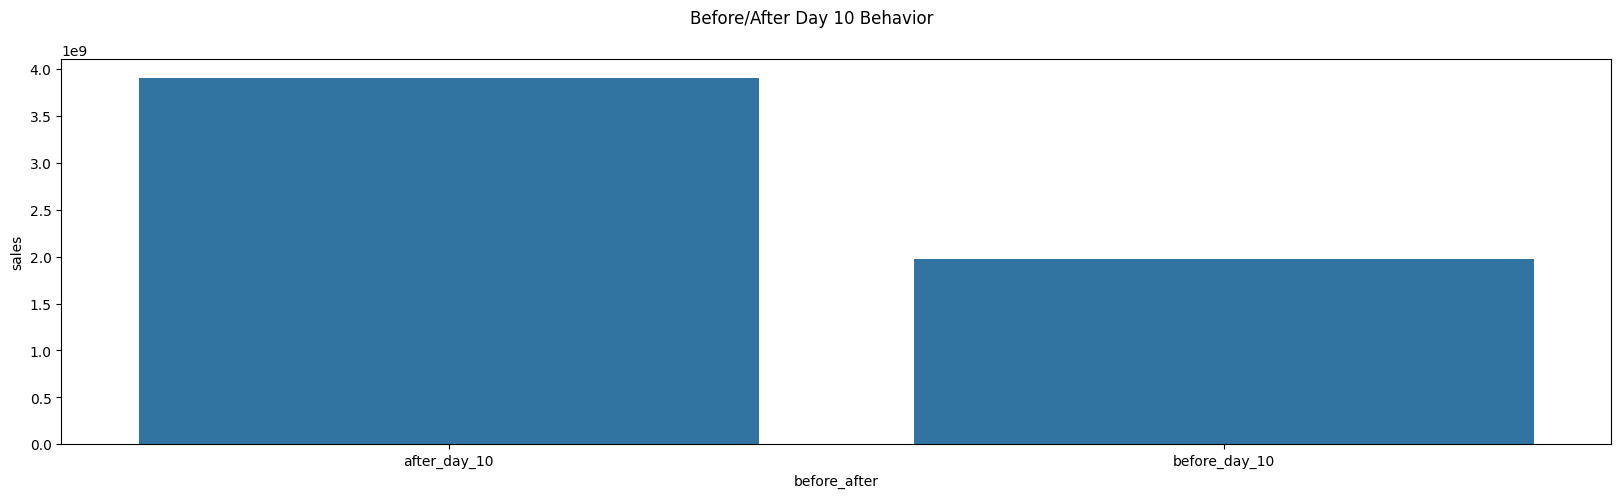

In [256]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

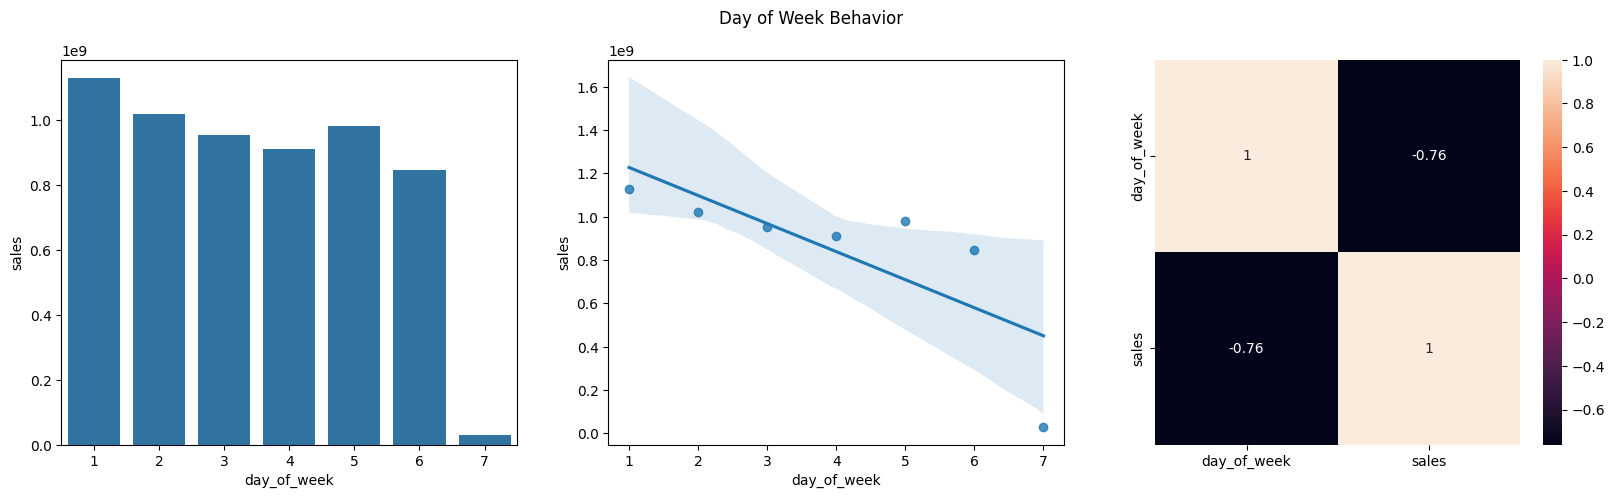

In [257]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

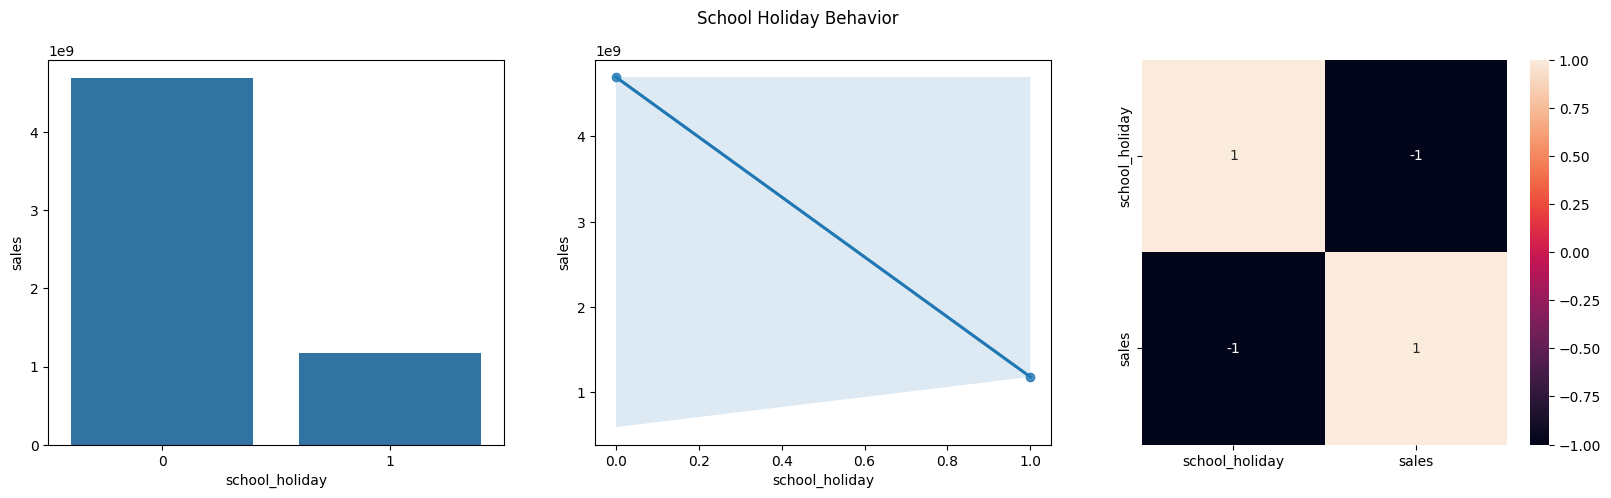

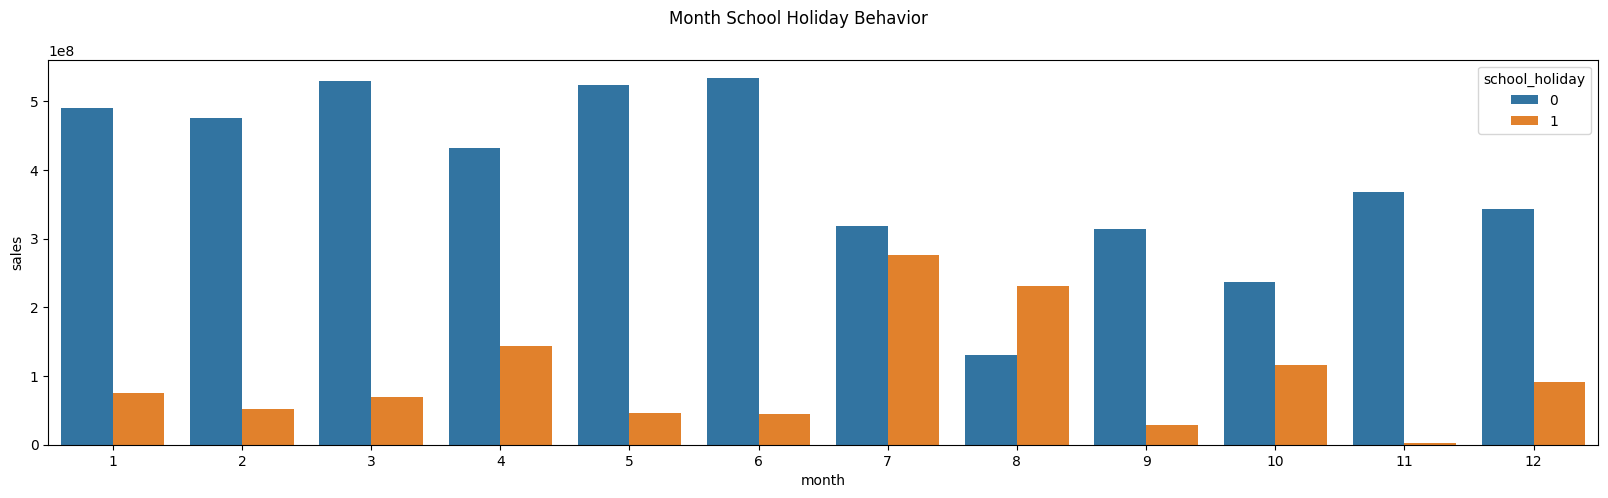

In [261]:
aux1 = df3[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df3[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );
#sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
#sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### 3.2.1 Resumo das Hipóteses

In [265]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

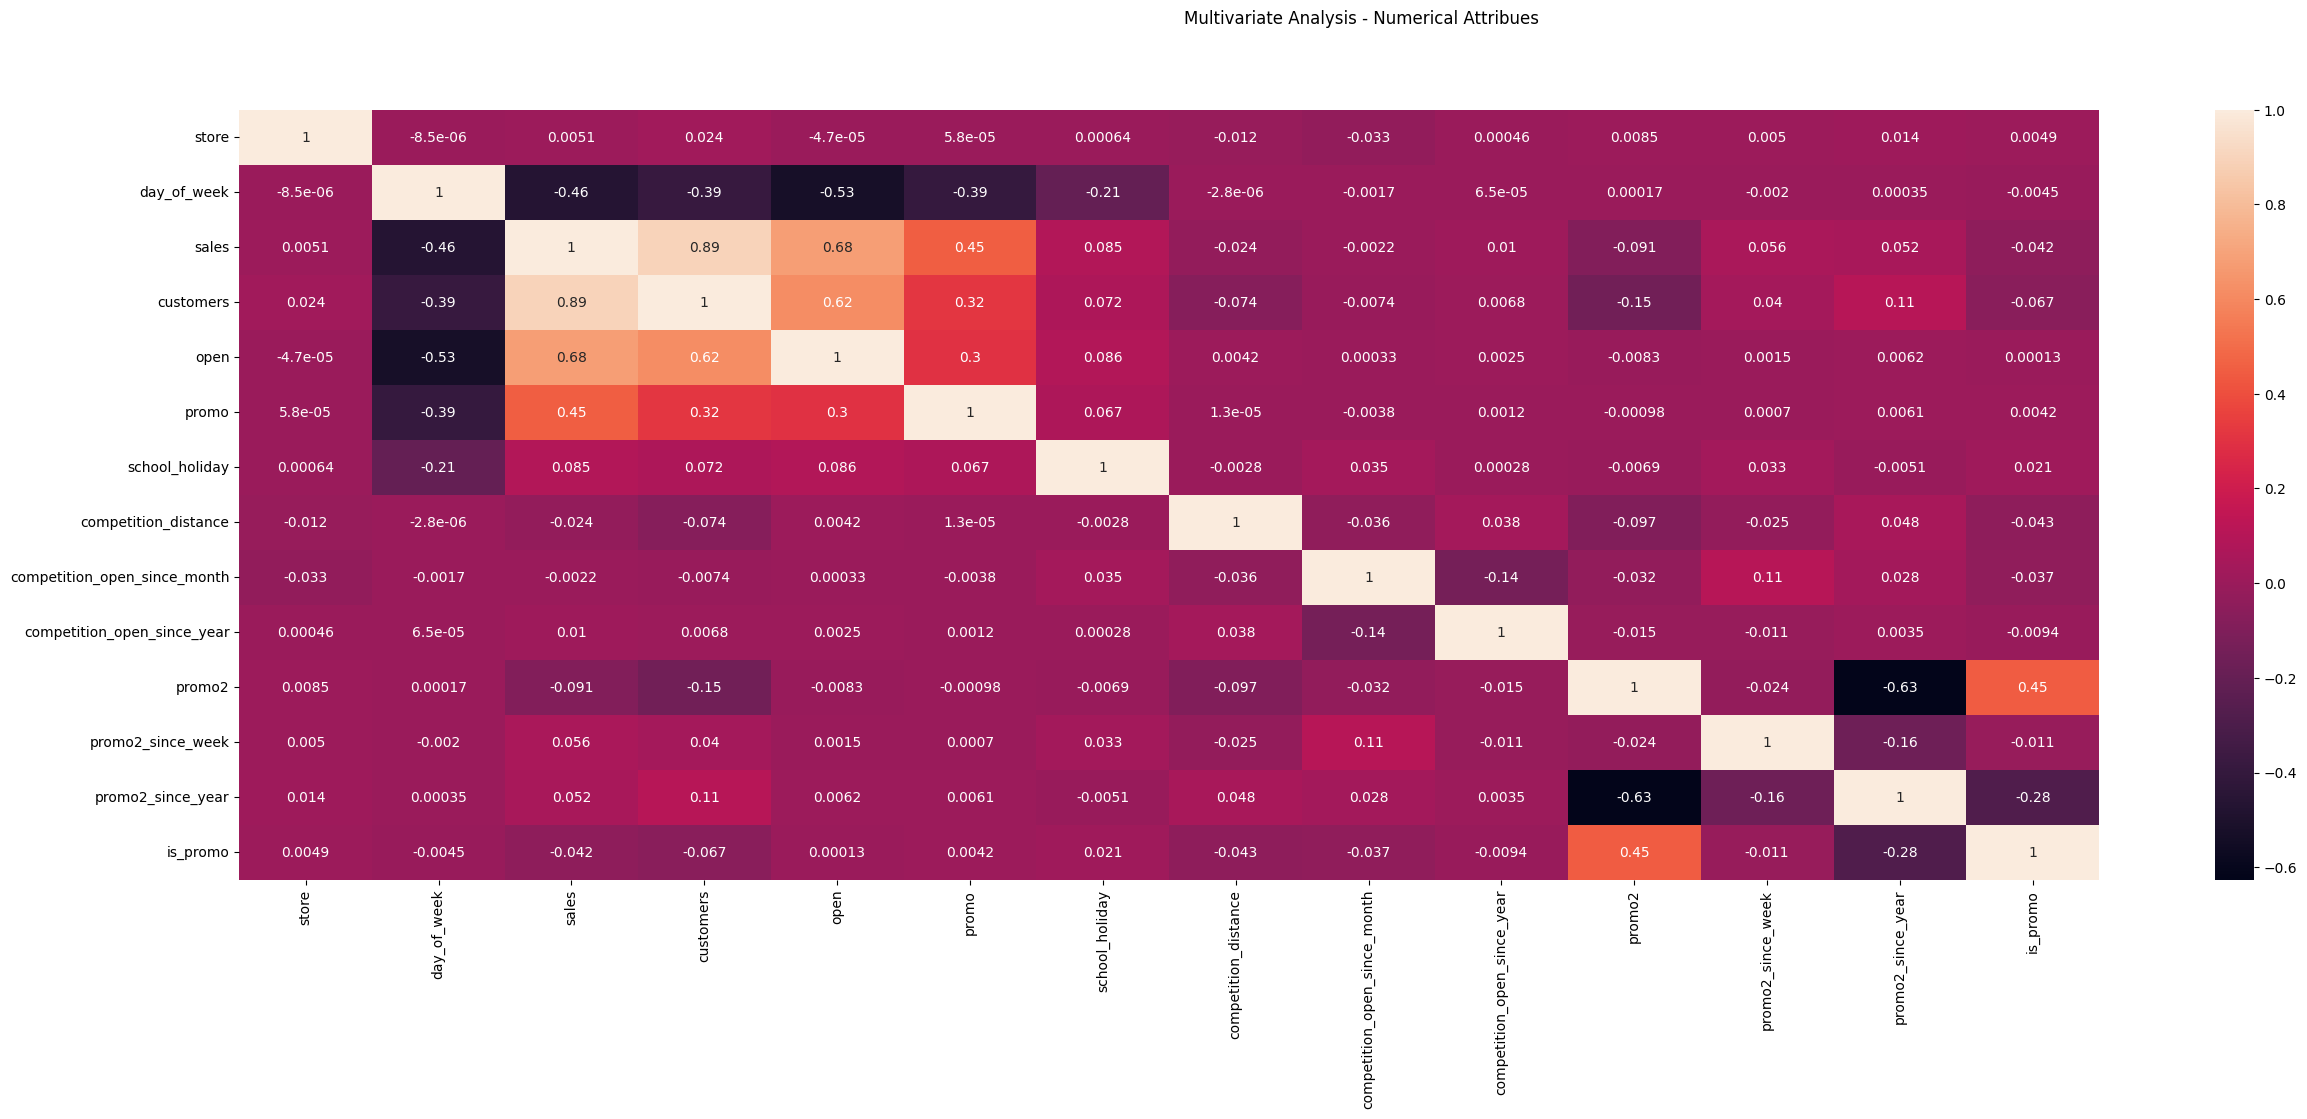

In [269]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [303]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
880571,regular day,a,extended,2013-18
895945,regular day,a,basic,2013-16
791389,regular day,d,extended,2013-30
234842,regular day,d,basic,2015-1
579373,regular day,d,extended,2014-5


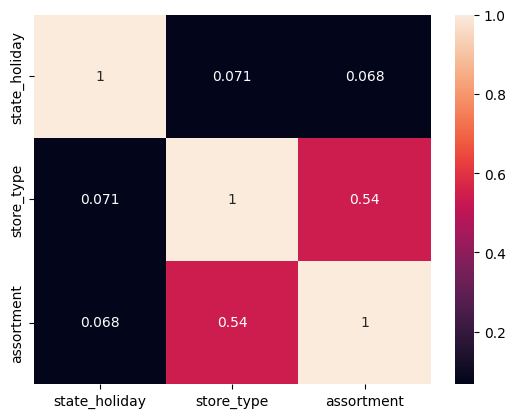

In [305]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);